In [1]:
import xarray as xr
from glob import glob
from datetime import datetime
import yaml
import sys
sys.path.append('../../')

import plotting

from ecco_pipeline.baseclasses import Grid
from ecco_pipeline.conf.global_settings import OUTPUT_DIR
from ecco_pipeline.utils.pipeline_utils.file_utils import get_date
from ecco_pipeline.utils.processing_utils.ds_functions import PreprocessingFuncs
from ecco_pipeline.transformations.grid_transformation import Transformation

In [2]:
ds_name = "ATL20_V004_monthly"
hemisphere = 'north'
with open(f'conf/ds_configs/{ds_name}.yaml', 'r') as stream:
    config = yaml.load(stream, yaml.Loader)

# Load sample granule

In [3]:
ds_granules_dir = f'{OUTPUT_DIR}/{ds_name}/harvested_granules/'
ds_granules = glob(f'{ds_granules_dir}/**/*.h5')
if hemisphere:
    ds_granules = [g for g in ds_granules if config['hemi_pattern'][hemisphere] in g]
sample_granule_path = ds_granules[0]
print(sample_granule_path)

/Users/marlis/Developer/ECCO/ecco_output/ATL20_V004_monthly/harvested_granules/2022/ATL20-01_20220201012600_06231401_004_01.h5


In [4]:
filename_date_str = get_date(config['filename_date_regex'], sample_granule_path.split('/')[-1])
granule_date = datetime.strptime(filename_date_str, config['filename_date_fmt']).strftime('%Y-%m-%dT%H:%M:%SZ')

# Load grid

In [5]:
grids = glob('grids/*.nc*')
grids.sort()
f'Available grids: {grids}'

"Available grids: ['grids/ECCO_llc270.nc', 'grids/ECCO_llc90.nc', 'grids/TPOSE.nc', 'grids/polar_stereo_n_25km.nc']"

In [6]:
grid_ds = xr.open_dataset(grids[1])
target_grid = Grid(grid_ds)
target_grid.ds

<xarray.Dataset>
Dimensions:                (tile: 13, j: 90, i: 90)
Coordinates:
  * tile                   (tile) int16 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j                      (j) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
  * i                      (i) int16 0 1 2 3 4 5 6 7 ... 82 83 84 85 86 87 88 89
Data variables:
    XC                     (tile, j, i) float32 ...
    YC                     (tile, j, i) float32 ...
    effective_grid_radius  (tile, j, i) float32 ...
Attributes:
    name:                  ECCO_llc90
    type:                  llc
    geospatial_lat_min:    -89.873055
    geospatial_lat_max:    89.739395
    geospatial_lon_min:    -179.98895
    geospatial_lon_max:    179.98691
    geospatial_lat_units:  degrees_north
    geospatial_lon_units:  degrees_east

In [7]:
T = Transformation(config, sample_granule_path, granule_date)

In [8]:
ds = PreprocessingFuncs().ATL20_V004_monthly(sample_granule_path, T.fields)
ds

<xarray.Dataset>
Dimensions:  (grid_x: 304, grid_y: 448, phony_dim_36: 1)
Coordinates:
  * grid_x   (grid_x) float64 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06
  * grid_y   (grid_y) float64 5.838e+06 5.812e+06 ... -5.312e+06 -5.338e+06
Dimensions without coordinates: phony_dim_36
Data variables:
    crs      (phony_dim_36) int8 ...
    mean_fb  (grid_y, grid_x) float32 ...
Attributes: (12/46)
    short_name:                         ATL20
    level:                              L3B
    title:                              SET_BY_META
    description:                        This data set (ATL20) contains daily ...
    Conventions:                        CF-1.7
    contributor_name:                   Alek Petty (alek.a.petty@nasa.gov), R...
    ...                                 ...
    processing_level:                   3B
    references:                         http://nsidc.org/data/icesat2/data.html
    project:                            ICESat-2 > Ice, Cloud, and land Eleva...
    instrument:                         ATLAS > Advanced Topographic Laser Al...
    platform:                           ICESat-2 > Ice, Cloud, and land Eleva...
    source:                             Spacecraft

# Make mapping factors

In [10]:
factors = T.make_factors(target_grid)

<class 'ecco_pipeline.baseclasses.Grid'>
Only using 100 nearest neighbours, but you may need up to 4609517
Creating ECCO_llc90 mapping factors...done.


# Transformation

In [11]:
field_ds_list = T.transform(target_grid, factors, ds)

In [12]:
field_ds = field_ds_list[0][0]
field_ds

<xarray.Dataset>
Dimensions:                             (time: 1, tile: 13, j: 90, i: 90, nv: 2)
Coordinates:
  * time                                (time) datetime64[ns] 2022-02-15
  * tile                                (tile) int16 0 1 2 3 4 ... 8 9 10 11 12
  * j                                   (j) int16 0 1 2 3 4 5 ... 85 86 87 88 89
  * i                                   (i) int16 0 1 2 3 4 5 ... 85 86 87 88 89
    XC                                  (tile, j, i) float32 -111.6 ... -111.9
    YC                                  (tile, j, i) float32 -88.24 ... -88.1
    time_bnds                           (time, nv) datetime64[ns] 2022-02-01 ...
Dimensions without coordinates: nv
Data variables:
    mean_fb_interpolated_to_ECCO_llc90  (time, tile, j, i) float64 9.969e+36 ...
Attributes:
    interpolated_grid:            ECCO_llc90
    model_grid_type:              llc
    original_dataset_title:       ATLAS/ICESat-2 L3B Daily and Monthly Gridde...
    original_dataset_short_name:  ATL20_V004
    original_dataset_url:         https://nsidc.org/data/atl20/versions/4
    original_dataset_reference:   https://nsidc.org/sites/default/files/atl20...
    original_dataset_doi:         10.5067/ATLAS/ATL20.004
    interpolated_grid_id:         ECCO_llc90
    transformation_version:       1.3
    notes:

# Visualization

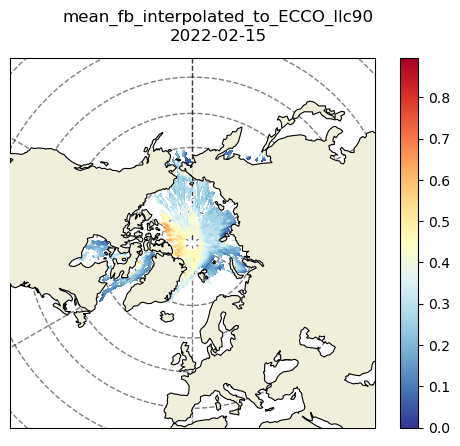

In [13]:
for field_ds in field_ds_list:
    plotting.make_plot(field_ds[0][list(field_ds[0].data_vars)[0]], 'nh')
